# Python tools for high-performance computing applications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## multiprocessing

Python has a built-in process-based library for concurrent computing, called `multiprocessing`. 

In [1]:
import multiprocessing
import os
import time
import numpy

In [3]:
def task(args):
    print("PID =", os.getpid(), ", args =", args)
    
    return os.getpid(), args

In [4]:
task("test")

PID = 298 , args = test


(298, 'test')

In [5]:
pool = multiprocessing.Pool(processes=4)

PID =PID =PID =PID =    478475477476   , args = , args = , args =, args =   41
32 PID =


 PID =PID =PID =478  477476475    , args =, args =, args =, args =    5867





In [6]:
result = pool.map(task, [1,2,3,4,5,6,7,8])

In [7]:
result

[(475, 1),
 (476, 2),
 (477, 3),
 (478, 4),
 (478, 5),
 (475, 6),
 (476, 7),
 (477, 8)]

The multiprocessing package is very useful for highly parallel tasks that do not need to communicate with each other, other than when sending the initial data to the pool of processes and when and collecting the results. 

## IPython parallel

IPython includes a very interesting and versatile parallel computing environment, which is very easy to use. It builds on the concept of ipython engines and controllers, that one can connect to and submit tasks to. To get started using this framework for parallel computing, one first have to start up an IPython cluster of engines. The easiest way to do this is to use the `ipcluster` command,

    $ ipcluster start -n 4

Or, alternatively, from the "Clusters" tab on the IPython notebook dashboard page. This will start 4 IPython engines on the current host, which is useful for multicore systems. It is also possible to setup IPython clusters that spans over many nodes in a computing cluster. For more information about possible use cases, see the official documentation [Using IPython for parallel computing](https://github.com/ipython/ipyparallel).

To use the IPython cluster in our Python programs or notebooks, we start by creating an instance of `IPython.parallel.Client`:

In [8]:
from ipyparallel import Client

In [10]:
cli = Client()

Using the 'ids' attribute we can retreive a list of ids for the IPython engines in the cluster:

In [11]:
cli.ids

[0, 1, 2, 3, 4, 5, 6, 7]

Each of these engines are ready to execute tasks. We can selectively run code on individual engines:

In [12]:
def getpid():
    """ return the unique ID of the current process """
    import os
    return os.getpid()

In [13]:
# first try it on the notebook process
getpid()

298

In [14]:
# run it on one of the engines
cli[0].apply_sync(getpid)

659

In [15]:
# run it on ALL of the engines at the same time
cli[:].apply_sync(getpid)

[659, 670, 664, 667, 673, 676, 679, 682]

We can use this cluster of IPython engines to execute tasks in parallel. The easiest way to dispatch a function to different engines is to define the function with the decorator:

    @view.parallel(block=True)

Here, `view` is supposed to be the engine pool which we want to dispatch the function (task). Once our function is defined this way we can dispatch it to the engine using the `map` method in the resulting class (in Python, a decorator is a language construct which automatically wraps the function into another function or a class).

To see how all this works, lets look at an example:

In [16]:
dview = cli[:]

In [17]:
@dview.parallel(block=True)
def dummy_task(delay):
    """ a dummy task that takes 'delay' seconds to finish """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()
    
    return [pid, t0, t1]

In [18]:
# generate random delay times for dummy tasks
delay_times = numpy.random.rand(8)
print(delay_times)

[0.62551144 0.98907046 0.94804709 0.22442557 0.52073388 0.16160201
 0.33929074 0.1558475 ]


Now, to map the function `dummy_task` to the random delay time data, we use the `map` method in `dummy_task`:

In [19]:
dummy_task.map(delay_times)

[[659, 1680192597.828465, 1680192598.455077],
 [670, 1680192597.8293047, 1680192598.8199067],
 [664, 1680192597.8293333, 1680192598.7789748],
 [667, 1680192597.8296752, 1680192598.0550234],
 [673, 1680192597.8299584, 1680192598.3514473],
 [676, 1680192597.8324006, 1680192597.994318],
 [679, 1680192597.832509, 1680192598.1727655],
 [682, 1680192597.8330102, 1680192597.9891958]]

Let's do the same thing again with many more tasks and visualize how these tasks are executed on different IPython engines:

In [20]:
def visualize_tasks(results):
    res = numpy.array(results)
    fig, ax = plt.subplots(figsize=(10, res.shape[1]))
    
    yticks = []
    yticklabels = []
    tmin = min(res[:,1])
    for n, pid in enumerate(numpy.unique(res[:,0])):
        yticks.append(n)
        yticklabels.append("%d" % pid)
        for m in numpy.where(res[:,0] == pid)[0]:
            ax.add_patch(plt.Rectangle((res[m,1] - tmin, n-0.25),
                         res[m,2] - res[m,1], 0.5, color="green", alpha=0.5))
        
    ax.set_ylim(-.5, n+.5)
    ax.set_xlim(0, max(res[:,2]) - tmin + 0.)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("PID")
    ax.set_xlabel("seconds")

In [46]:
delay_times = numpy.random.rand(64)
print(delay_times)

[5.08673019e-01 5.21248918e-01 9.37000879e-01 2.62594152e-01
 2.46715366e-01 6.29382625e-02 1.49458843e-01 9.23689080e-04
 7.01777938e-01 2.53845620e-02 9.09201648e-01 5.49010689e-01
 6.12745772e-01 4.61362579e-01 6.02703268e-01 4.08528464e-01
 2.52333139e-01 4.06861273e-01 2.11692988e-01 2.21936706e-01
 4.33712849e-02 6.93458092e-01 5.98739012e-01 7.28452708e-01
 9.63025764e-01 8.20139920e-01 4.84952863e-01 7.23705994e-01
 2.97005315e-01 4.91416962e-01 7.66644288e-01 9.03968845e-01
 5.77943919e-02 7.92508731e-01 7.07495988e-01 2.15057380e-01
 8.28571842e-01 5.55710946e-01 1.98197811e-01 2.19737155e-01
 9.88001831e-01 8.35521893e-01 2.09216259e-01 6.74658258e-01
 4.28234249e-02 8.78636720e-01 4.67096668e-01 1.20270674e-01
 4.77083098e-01 8.89118749e-01 7.35219218e-01 8.32391477e-01
 4.08706468e-01 4.63351157e-01 1.33254250e-01 8.27603753e-01
 3.31142847e-01 9.77621405e-01 8.63865722e-01 5.61788341e-01
 6.22267752e-01 6.22353068e-01 8.78352414e-01 6.44819857e-01]


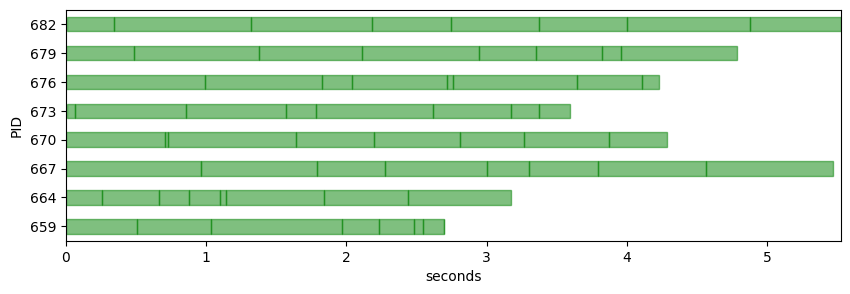

In [47]:
result = dummy_task.map(delay_times)
visualize_tasks(result)

That's a nice and easy parallelization! We can see that we utilize all four engines quite well.

But one short coming so far is that the tasks are not load balanced, so one engine might be idle while others still have more tasks to work on.

However, the IPython parallel environment provides a number of alternative "views" of the engine cluster, and there is a view that provides load balancing as well (above we have used the "direct view", which is why we called it "dview").

To obtain a load balanced view we simply use the `load_balanced_view` method in the engine cluster client instance `cli`:

In [48]:
lbview = cli.load_balanced_view()

In [49]:
@lbview.parallel(block=True)
def dummy_task_load_balanced(delay):
    """ a dummy task that takes 'delay' seconds to finish """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()
    
    return [pid, t0, t1]

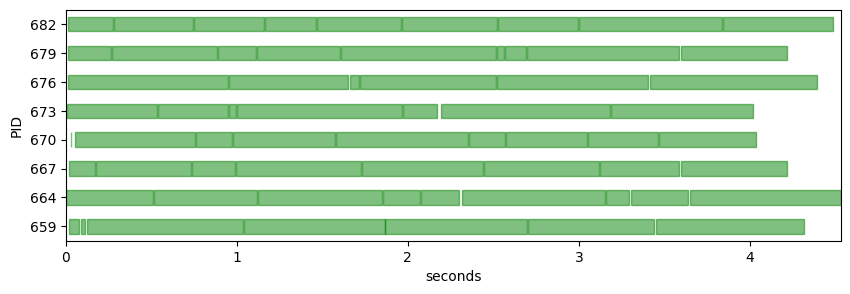

In [50]:
result = dummy_task_load_balanced.map(delay_times)
visualize_tasks(result)

In the example above we can see that the engine cluster is a bit more efficiently used, and the time to completion is shorter than in the previous example.

## Calculating $\pi$ in parallel

Below: Serial function

In [57]:
def mc_pi(n):
    count = 0
    rvec = numpy.random.random((n,2))
    r = numpy.sum(rvec**2, axis=1)
    inside = numpy.sum(r < 1)
    return 4 * inside / float(n)

In [58]:
Nmc = 100000
time0 = time.time()
print(mc_pi(Nmc))
time1 = time.time()
print(f"Took {time1-time0} seconds")

3.14972
Took 0.008175134658813477 seconds


In [59]:
with dview.sync_imports():
    import numpy

importing numpy on engine(s)


Distribute the calculate to all of the parallel engines

In [60]:
[Nmc//nproc]*nproc

[12500, 12500, 12500, 12500, 12500, 12500, 12500, 12500]

In [61]:
nproc = len(cli)
est_pis = dview.map_sync(mc_pi, [Nmc//nproc]*nproc)
time0 = time.time()
print(numpy.sum(est_pis)/nproc)
time1 = time.time()
print(f"Took {time1-time0} seconds")

3.15592
Took 0.00022172927856445312 seconds


In [56]:
0.6/0.00242

247.93388429752068

### Further reading

There are many other ways to use the IPython parallel environment. The official documentation has a nice guide:

* https://github.com/ipython/ipyparallel

## MPI

When more communication between processes is required, sophisticated solutions such as MPI and OpenMP are often needed. MPI is process based parallel processing library/protocol, and can be used in Python programs through the `mpi4py` package:

http://mpi4py.scipy.org/

After using a package manager (apt on Linux, brew on macOS) to install OpenMPI, you can use `pip install mpi4py` to install mpi4py.  To use the `mpi4py` package we include `MPI` from `mpi4py`:

    from mpi4py import MPI

A MPI python program must be started using the `mpirun -n N` command, where `N` is the number of processes that should be included in the process group.

Note that the IPython parallel enviroment also has support for MPI, but to begin with we will use `mpi4py` and the `mpirun` in the follow examples.

### Example 1

In [ ]:
%%file mpitest.py

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
   data = [1.0, 2.0, 3.0, 4.0]
   comm.send(data, dest=1, tag=11)
elif rank == 1:
   data = comm.recv(source=0, tag=11)
    
print ("rank =", rank, ", data =", data)

In [ ]:
!mpirun -n 2 python mpitest.py

### Example 2

Send a numpy array from one process to another:

In [21]:
%%file mpi-numpy-array.py

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
   data = numpy.random.rand(10)
   comm.Send(data, dest=1, tag=13)
elif rank == 1:
   data = numpy.empty(10, dtype=numpy.float64)
   comm.Recv(data, source=0, tag=13)
   data += 1
    
print ("rank =", rank, ", data =", data)

Overwriting mpi-numpy-array.py


In [22]:
!mpirun -n 2 python mpi-numpy-array.py

rank = 0 , data = [0.63602207 0.16732044 0.08204503 0.12160661 0.37254777 0.58498329
 0.71443695 0.8064738  0.51237994 0.27391813]
rank = 1 , data = [1.63602207 1.16732044 1.08204503 1.12160661 1.37254777 1.58498329
 1.71443695 1.8064738  1.51237994 1.27391813]


### Example 3: Matrix-vector multiplication

In [ ]:
# prepare some random data
N = 16
A = numpy.random.rand(N, N)
numpy.save("random-matrix.npy", A)
x = numpy.random.rand(N)
numpy.save("random-vector.npy", x)

In [ ]:
%%file mpi-matrix-vector.py

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
p = comm.Get_size()

def matvec(comm, A, x):
    m = A.shape[0] // p
    y_part = numpy.dot(A[rank * m:(rank+1)*m], x)
    y = numpy.zeros_like(x)
    comm.Allgather([y_part,  MPI.DOUBLE], [y, MPI.DOUBLE])
    return y

A = numpy.load("random-matrix.npy")
x = numpy.load("random-vector.npy")
y_mpi = matvec(comm, A, x)

if rank == 0:
    y = numpy.dot(A, x)
    print(y_mpi)
    print("sum(y - y_mpi) =", (y - y_mpi).sum())

In [ ]:
!mpirun -n 4 python mpi-matrix-vector.py

### Example 4: Sum of the elements in a vector

In [ ]:
# prepare some random data
N = 128
a = numpy.random.rand(N)
numpy.save("random-vector.npy", a)

In [ ]:
%%file mpi-psum.py

from mpi4py import MPI
import numpy as np

def psum(a):
    r = MPI.COMM_WORLD.Get_rank()
    size = MPI.COMM_WORLD.Get_size()
    m = len(a) // size
    locsum = np.sum(a[r*m:(r+1)*m])
    rcvBuf = np.array(0.0, 'd')
    MPI.COMM_WORLD.Allreduce([locsum, MPI.DOUBLE], [rcvBuf, MPI.DOUBLE], op=MPI.SUM)
    return rcvBuf

a = np.load("random-vector.npy")
s = psum(a)

if MPI.COMM_WORLD.Get_rank() == 0:
    print("sum =", s, ", numpy sum =", a.sum())

In [ ]:
!mpirun -n 4 python mpi-psum.py

### Further reading

* http://mpi4py.scipy.org

* http://mpi4py.scipy.org/docs/usrman/tutorial.html

* https://computing.llnl.gov/tutorials/mpi/

## OpenMP

What about OpenMP? OpenMP is a standard and widely used thread-based parallel API that unfortunaltely is **not** useful directly in Python. The reason is that the CPython implementation use a global interpreter lock, making it impossible to simultaneously run several Python threads. Threads are therefore not useful for parallel computing in Python, unless it is only used to wrap compiled code that do the OpenMP parallelization (Numpy can do something like that). 

This is clearly a limitation in the Python interpreter, and as a consequence all parallelization in Python must use processes (not threads).

However, there is a way around this that is not that painful. When calling out to compiled code the GIL is released, and it is possible to write Python-like code in Cython where we can selectively release the GIL and do OpenMP computations. 

In [ ]:
N_core = multiprocessing.cpu_count()

print("This system has %d cores" % N_core)

Here is a simple example that shows how OpenMP can be used via cython:

In [2]:
%load_ext Cython

In [3]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force -a
#%%cython -f -c-fopenmp --link-args=-fopenmp -c-g

cimport cython
cimport numpy
from cython.parallel import prange, parallel
cimport openmp

def cy_openmp_test():

    cdef int n, N

    # release GIL so that we can use OpenMP
    with nogil, parallel():
        N = openmp.omp_get_num_threads()
        n = openmp.omp_get_thread_num()
        with gil:
            print("Number of threads %d: thread number %d\n" % (N, n))

In file included from /home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/jwise/.cache/ipython/cython/_cython_magic_8e54d9f6c8facdb3031723bb31a50924.c:775:
/home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [4]:
cy_openmp_test()

Number of threads 8: thread number 0

Number of threads 8: thread number 5

Number of threads 8: thread number 2

Number of threads 8: thread number 3

Number of threads 8: thread number 1

Number of threads 8: thread number 7

Number of threads 8: thread number 6

Number of threads 8: thread number 4



### Example: matrix vector multiplication

In [6]:
# prepare some random data
N_core = 4
N = 4 * N_core

M = numpy.random.rand(N, N)
x = numpy.random.rand(N)
y = numpy.zeros_like(x)

Let's first look at a simple implementation of matrix-vector multiplication in Cython:

In [7]:
%%cython

cimport cython
cimport numpy
import numpy

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_matvec(numpy.ndarray[numpy.float64_t, ndim=2] M, 
              numpy.ndarray[numpy.float64_t, ndim=1] x, 
              numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x)

    for i from 0 <= i < n:
        for j from 0 <= j < n:
            y[i] += M[i, j] * x[j]
            
    return y

In [8]:
# check that we get the same results
y = numpy.zeros_like(x)
cy_matvec(M, x, y)
numpy.dot(M, x) - y

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -4.4408921e-16, -8.8817842e-16,  0.0000000e+00, -8.8817842e-16,
        8.8817842e-16, -8.8817842e-16,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  8.8817842e-16,  8.8817842e-16,  8.8817842e-16])

In [9]:
%timeit numpy.dot(M, x)

1.07 µs ± 45.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
%timeit cy_matvec(M, x, y)

910 ns ± 217 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


The Cython implementation here is a bit slower than numpy.dot, but not by much, so if we can use multiple cores with OpenMP it should be possible to beat the performance of numpy.dot.

In [11]:
%%cython -f -c-fopenmp --link-args=-fopenmp -c-g

cimport cython
cimport numpy
from cython.parallel import parallel
cimport openmp

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_matvec_omp(numpy.ndarray[numpy.float64_t, ndim=2] M, 
                  numpy.ndarray[numpy.float64_t, ndim=1] x, 
                  numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x), N, r, m

    # release GIL, so that we can use OpenMP
    with nogil, parallel():
        N = openmp.omp_get_num_threads()
        r = openmp.omp_get_thread_num()
        m = n // N
        
        for i from 0 <= i < m:
            for j from 0 <= j < n:
                y[r * m + i] += M[r * m + i, j] * x[j]

    return y

In file included from /home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/jwise/.cache/ipython/cython/_cython_magic_9590dd1f1660b1f6514b705f9fe72a28.c:777:
/home/jwise/.local/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [12]:
# check that we get the same results
y = numpy.zeros_like(x)
cy_matvec_omp(M, x, y)
numpy.dot(M, x) - y

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -4.4408921e-16, -8.8817842e-16,  0.0000000e+00, -8.8817842e-16,
        8.8817842e-16, -8.8817842e-16,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  8.8817842e-16,  8.8817842e-16,  8.8817842e-16])

In [13]:
%timeit numpy.dot(M, x)

1.09 µs ± 60.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [14]:
%timeit cy_matvec_omp(M, x, y)

1.25 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now, this implementation is much slower than numpy.dot for this problem size, because of overhead associated with OpenMP and threading, etc. But let's look at the how the different implementations compare with larger matrix sizes:

In [15]:
N_vec  = numpy.arange(25, 500, 25) * N_core

In [16]:
duration_ref = numpy.zeros(len(N_vec))
duration_cy = numpy.zeros(len(N_vec))
duration_cy_omp = numpy.zeros(len(N_vec))

for idx, N in enumerate(N_vec):
    
    M = numpy.random.rand(N, N)
    x = numpy.random.rand(N)
    y = numpy.zeros_like(x)
    
    t0 = time.time()
    numpy.dot(M, x)
    duration_ref[idx] = time.time() - t0
    
    t0 = time.time()
    cy_matvec(M, x, y)
    duration_cy[idx] = time.time() - t0
    
    t0 = time.time()
    cy_matvec_omp(M, x, y)
    duration_cy_omp[idx] = time.time() - t0

In [17]:
print(idx, N)

18 1900


In [19]:
import matplotlib.pyplot as plt

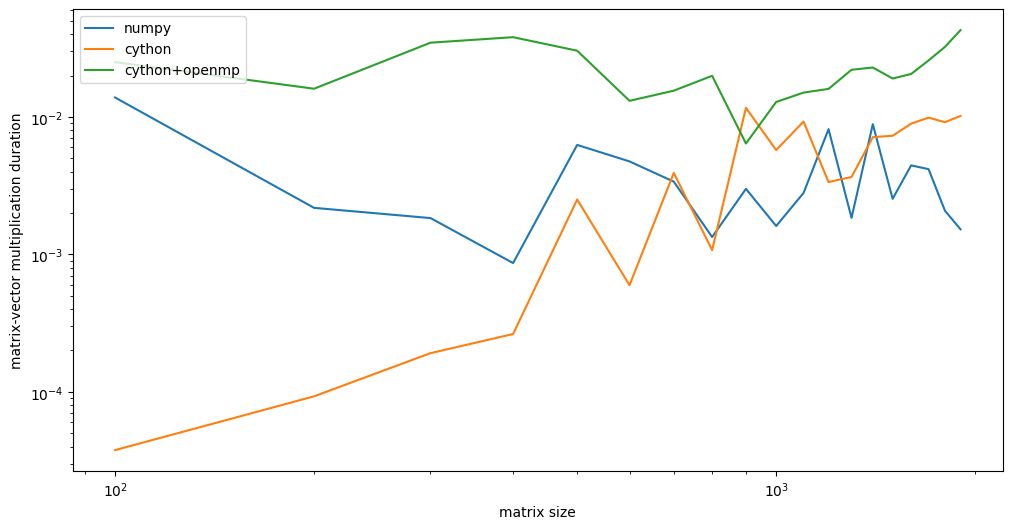

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.loglog(N_vec, duration_ref, label='numpy')
ax.loglog(N_vec, duration_cy, label='cython')
ax.loglog(N_vec, duration_cy_omp, label='cython+openmp')

ax.legend(loc=2)
ax.set_yscale("log")
ax.set_ylabel("matrix-vector multiplication duration")
ax.set_xlabel("matrix size");

For large problem sizes the the cython+OpenMP implementation is faster than numpy.dot.

With this simple implementation, the speedup for large problem sizes is about:

In [ ]:
((duration_ref / duration_cy_omp)[-10:]).mean()

 Obviously one could do a better job with more effort, since the theoretical limit of the speed-up is:

In [ ]:
N_core

### Further reading

 * http://openmp.org
 * http://docs.cython.org/src/userguide/parallelism.html

## OpenCL (not working on my machine)

OpenCL is an API for heterogenous computing, for example using GPUs for numerical computations. There is a python package called `pyopencl` that allows OpenCL code to be compiled, loaded and executed on the compute units completely from within Python. This is a nice way to work with OpenCL, because the time-consuming computations should be done on the compute units in compiled code, and in this Python only server as a control language.

In [ ]:
%%file opencl-dense-mv.py

import pyopencl as cl
import numpy
import time

# problem size
n = 10000

# platform
platform_list = cl.get_platforms()
platform = platform_list[0]

# device
device_list = platform.get_devices()
device = device_list[0]

if True:
    print("Platform name:" + platform.name)
    print("Platform version:" + platform.version)
    print("Device name:" + device.name)
    print("Device type:" + cl.device_type.to_string(device.type))
    print("Device memory: " + str(device.global_mem_size//1024//1024) + ' MB')
    print("Device max clock speed:" + str(device.max_clock_frequency) + ' MHz')
    print("Device compute units:" + str(device.max_compute_units))

# context
ctx = cl.Context([device]) # or we can use cl.create_some_context()

# command queue
queue = cl.CommandQueue(ctx)

# kernel
KERNEL_CODE = """
//
// Matrix-vector multiplication: r = m * v
//
#define N %(mat_size)d
__kernel
void dmv_cl(__global float *m, __global float *v, __global float *r)
{
    int i, gid = get_global_id(0);
    
    r[gid] = 0;
    for (i = 0; i < N; i++)
    {
        r[gid] += m[gid * N + i] * v[i];
    }
}
"""

kernel_params = {"mat_size": n}
program = cl.Program(ctx, KERNEL_CODE % kernel_params).build()

# data
A = numpy.random.rand(n, n)
x = numpy.random.rand(n, 1)

# host buffers
h_y = numpy.empty(numpy.shape(x)).astype(numpy.float32)
h_A = numpy.real(A).astype(numpy.float32)
h_x = numpy.real(x).astype(numpy.float32)

# device buffers
mf = cl.mem_flags
d_A_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=h_A)
d_x_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=h_x)
d_y_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=h_y.nbytes)

# execute OpenCL code
t0 = time.time()
event = program.dmv_cl(queue, h_y.shape, None, d_A_buf, d_x_buf, d_y_buf)
event.wait()
cl.enqueue_copy(queue, h_y, d_y_buf)
t1 = time.time()

print ("opencl elapsed time =", (t1-t0))

# Same calculation with numpy
t0 = time.time()
y = numpy.dot(h_A, h_x)
t1 = time.time()

print ("numpy elapsed time =", (t1-t0))

# see if the results are the same
print ("max deviation =", numpy.abs(y-h_y).max())

In [ ]:
!python opencl-dense-mv.py

### Further reading

* http://mathema.tician.de/software/pyopencl